In [2]:
import joblib
import pandas as pd
import numpy as np

# 选择需要归一化的列
columns_to_normalize_X = ['time_order', 'provincial_load_forecast', 'tie_line_load_forecast',
                        'total_power_forecast', 'new_energy_power_forecast',
                        'hydraulic_power_forecast', 'non_market_power_forecast']
columns_to_normalize_Y = ['dayahead_clearing_price']
# # 加载 scaler
scalerX = joblib.load('./data/scalerX.joblib')
scalerY = joblib.load('./data/scalerY.joblib')
data_train = pd.read_feather('./data/train_data.feather')
data_val = pd.read_feather('./data/val_data.feather')
data_test = pd.read_feather('./data/test_data.feather')

# 对上面的数据集进行归一化
data_train[columns_to_normalize_X] = scalerX.transform(data_train[columns_to_normalize_X])
data_test[columns_to_normalize_X] = scalerX.transform(data_test[columns_to_normalize_X])

data_train[columns_to_normalize_Y] = scalerY.transform(data_train[columns_to_normalize_Y])




In [3]:
trainX = data_train.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_train.iloc[:, -1].values # 第9列作为因变量

testX = data_test.iloc[:, 1:-1].values  # 前8列作为自变量
testY = data_test.iloc[:, -1].values # 第9列作为因变量

In [4]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX, trainY)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY, predY)
rmse = np.sqrt(mean_squared_error(trainY, predY))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)
predY = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY)
rmse = np.sqrt(mean_squared_error(testY, predY))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: -0.06618283193236879
Coefficients: [ 0.12114226  0.0285131  -0.12565492 -0.18267085 -0.40992191 -0.16969735
  0.0103552 ]
Train RMSE: 0.7732, Train MAE: 0.6376
Test RMSE: 170.7490, Test MAE: 140.7526, Test MAPE: 83.4234


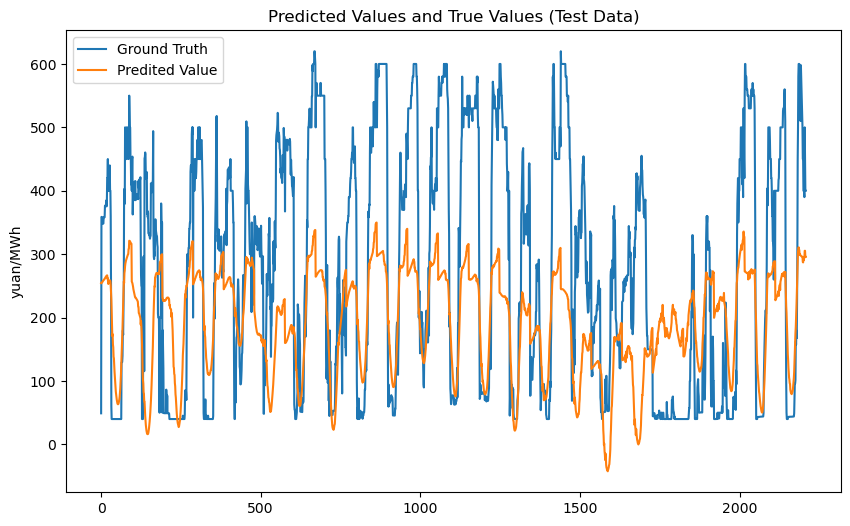

In [5]:
import matplotlib.pyplot as plt

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 1.4559, Train MAE: 1.1085
Test RMSE: 298.4559, Test MAE: 233.0990, Test MAPE: 100.9503


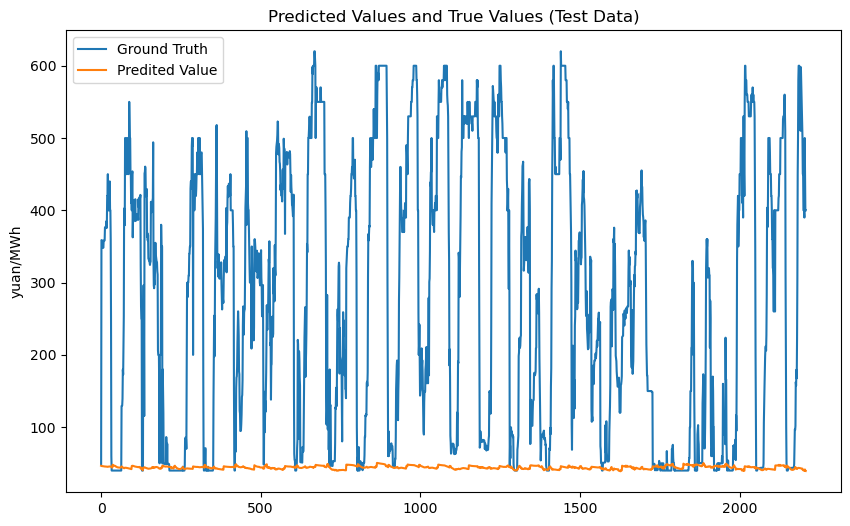

In [6]:
# RANSAC 回归（随机抽样一致性算法）
from sklearn.linear_model import RANSACRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = RANSACRegressor(max_trials=10000, residual_threshold=0.2)

# 拟合模型
model.fit(trainX, trainY)


# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.5466, Train MAE: 0.3836
Test RMSE: 151.1290, Test MAE: 117.6509, Test MAPE: 100.2389


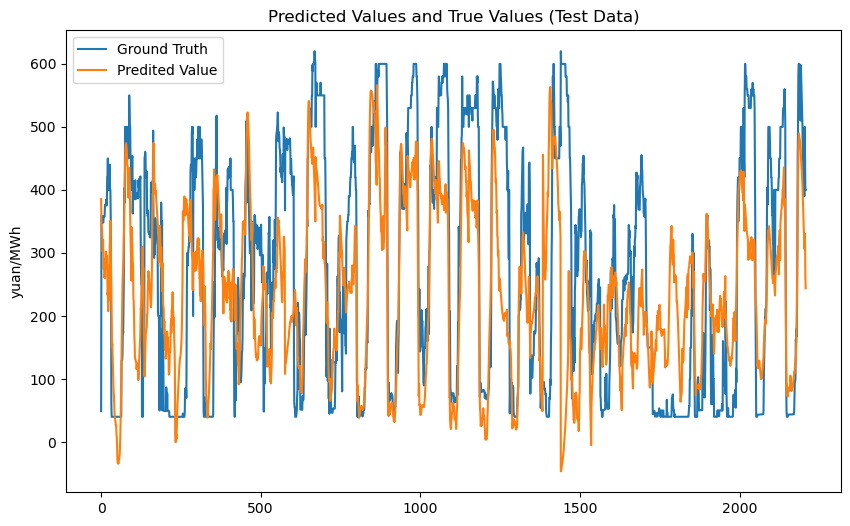

In [7]:
# SVR 回归（支持向量回归）
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = SVR(C=10)

# 拟合模型
model.fit(trainX, trainY)



# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.4475, Train MAE: 0.3381
Test RMSE: 143.5724, Test MAE: 112.7088, Test MAPE: 100.3661


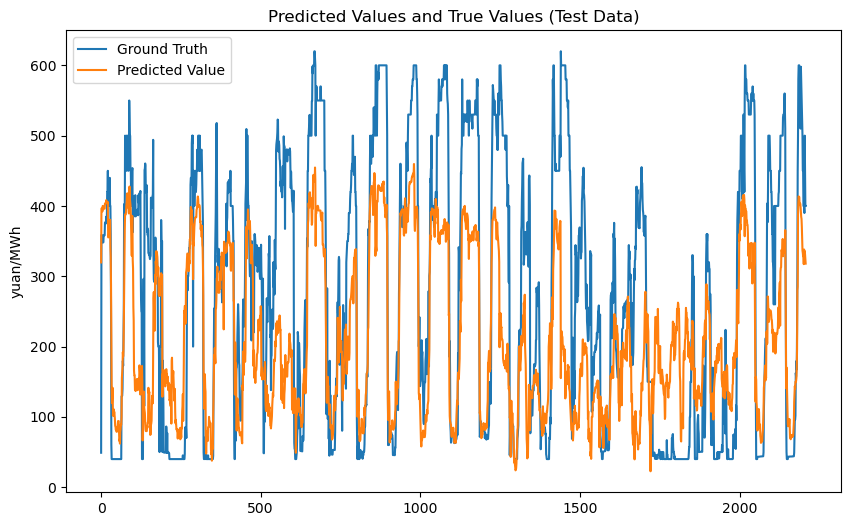

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.2547, Train MAE: 0.1786
Test RMSE: 145.5783, Test MAE: 114.6100, Test MAPE: 100.3121


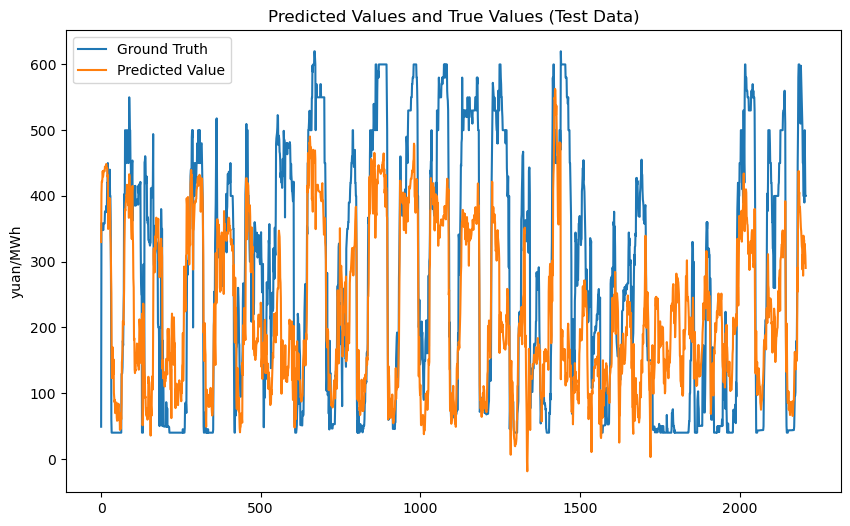

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


In [21]:
import pandas as pd
from sklearn.utils import resample

# 假设data为DataFrame，且包含'price'列
threshold = (400 - scalerY.mean_)/(scalerY.var_)**0.5  # 设置高值阈值
threshold = threshold[0]
high_value_data_train = data_train[data_train['dayahead_clearing_price'] > threshold]
low_value_data_train = data_train[data_train['dayahead_clearing_price'] <= threshold]

# 过采样高值数据，使其样本数接近低值数据
high_value_upsampled = resample(high_value_data_train, 
                                replace=True,   # 允许重复采样
                                n_samples=len(low_value_data_train),  # 使样本数平衡
                                random_state=42)

# 合并数据
data_upsampled = pd.concat([low_value_data_train, high_value_upsampled])


In [25]:
trainX = data_upsampled.iloc[:, 1:-1].values  # 前8列作为自变量
trainY = data_upsampled.iloc[:, -1].values # 第9列作为因变量

In [27]:

# 最小二乘
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
# 创建最小二乘回归模型
model = LinearRegression()

# 拟合模型
model.fit(trainX, trainY)

# 获取模型的截距和系数
intercept = model.intercept_  # XGBoost模型没有截距
coefficients = model.coef_  # XGBoost模型没有系数

print("Intercept:", intercept)
print("Coefficients:", coefficients)  # XGBoost模型没有系数

predY = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）

mae = mean_absolute_error(trainY, predY)
rmse = np.sqrt(mean_squared_error(trainY, predY))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse, mae))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)
predY = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY)
rmse = np.sqrt(mean_squared_error(testY, predY))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))


Intercept: 0.3101597649851193
Coefficients: [ 0.19771641 -0.06026731 -0.17386036 -0.29670518 -0.43649902 -0.23311874
  0.01978997]
Train RMSE: 0.8023, Train MAE: 0.6023
Test RMSE: 146.9126, Test MAE: 122.9448, Test MAPE: 104.6776


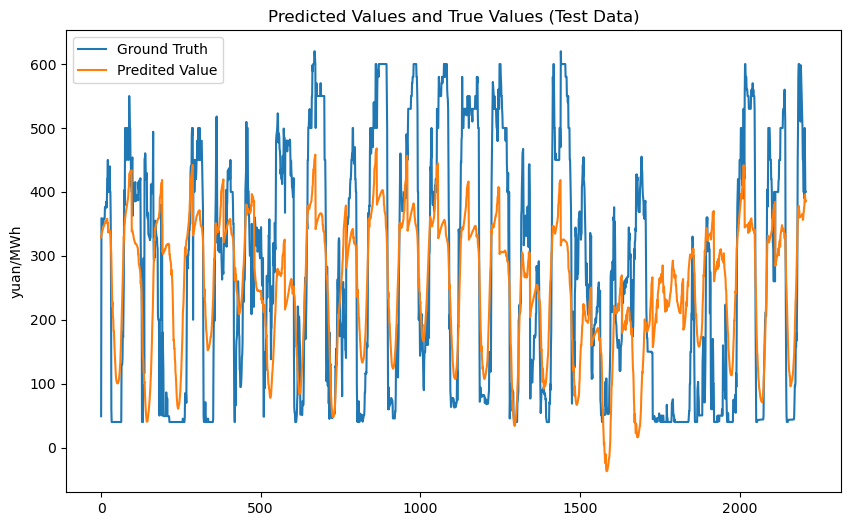

In [28]:
import matplotlib.pyplot as plt

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.4915, Train MAE: 0.3102
Test RMSE: 180.5056, Test MAE: 134.3695, Test MAPE: 100.2006


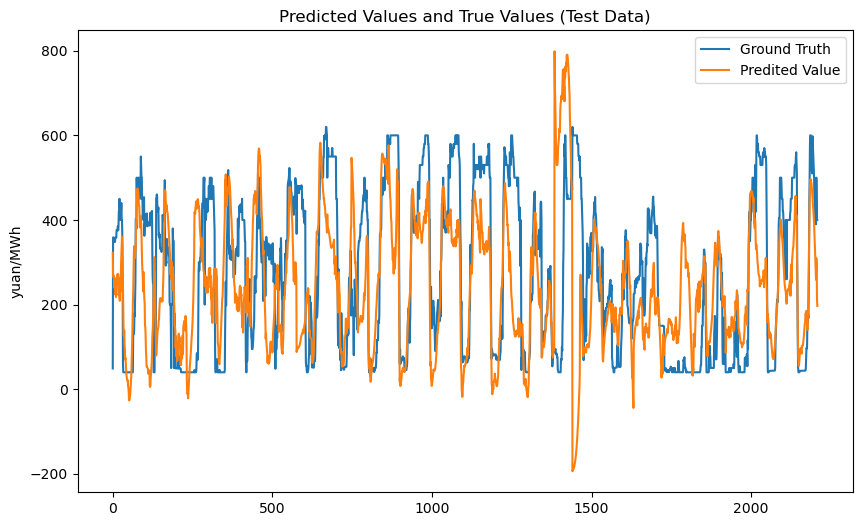

In [31]:
# SVR 回归（支持向量回归）
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = SVR(C=10)

# 拟合模型
model.fit(trainX, trainY)



# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

Train RMSE: 0.3781, Train MAE: 0.2585
Test RMSE: 136.8732, Test MAE: 105.8678, Test MAPE: 100.3269


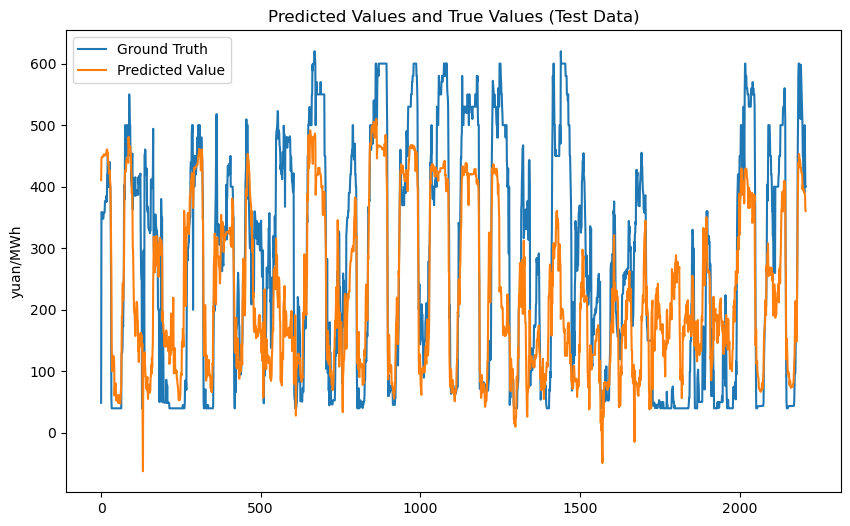

In [32]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.2155, Train MAE: 0.1318
Test RMSE: 149.5853, Test MAE: 114.9866, Test MAPE: 100.3530


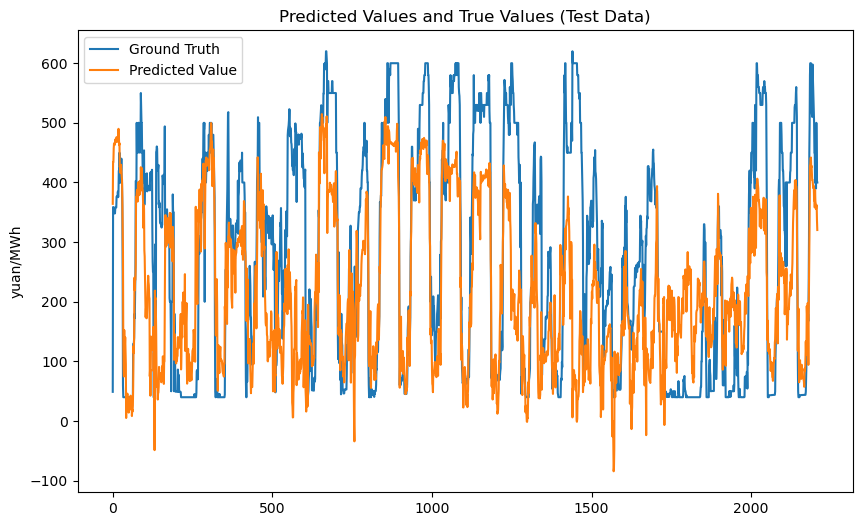

In [33]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 创建 XGBoost 模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1)

# 拟合模型
model.fit(trainX, trainY)

# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型在训练集上的性能指标
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 反归一化测试集预测结果
predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()

# 计算模型在测试集上的性能指标
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# 绘制测试数据的真实值与预测值
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Ground Truth')
plt.plot(predY_test, label='Predicted Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()


Train RMSE: 0.9725, Train MAE: 0.6717
Test RMSE: 160.1983, Test MAE: 118.5700, Test MAPE: 100.1281


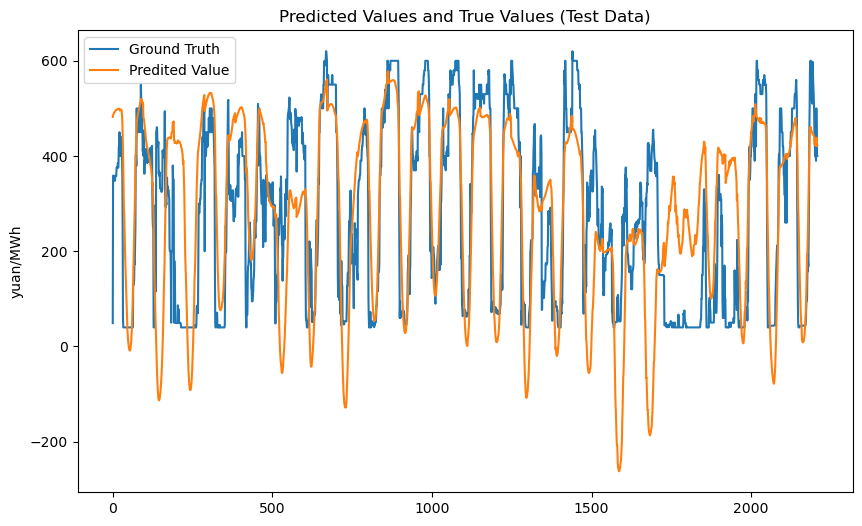

In [34]:
# RANSAC 回归（随机抽样一致性算法）
from sklearn.linear_model import RANSACRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


model = RANSACRegressor(max_trials=10000, residual_threshold=0.2)

# 拟合模型
model.fit(trainX, trainY)


# 使用训练好的模型对训练数据进行预测
predY_train = model.predict(trainX)

# 计算模型的在训练集上的性能指标（例如MAE、RMSE等）
mae_train = mean_absolute_error(trainY, predY_train)
rmse_train = np.sqrt(mean_squared_error(trainY, predY_train))
print('Train RMSE: {:.4f}, Train MAE: {:.4f}'.format(rmse_train, mae_train))

# 使用训练好的模型对测试数据进行预测
predY = model.predict(testX)

# 计算模型的在测试集上的性能指标（例如MAE、RMSE等）

predY_test = scalerY.inverse_transform(predY.reshape(-1, 1)).flatten()
mae = mean_absolute_error(testY, predY_test)
rmse = np.sqrt(mean_squared_error(testY, predY_test))
mape = np.mean(np.abs((testY - predY) / testY)) * 100
print('Test RMSE: {:.4f}, Test MAE: {:.4f}, Test MAPE: {:.4f}'.format(rmse, mae, mape))

# Plotting the true values against the predicted values for test data
plt.figure(figsize=(10, 6))
plt.plot(testY,label='Ground Truth')
plt.plot(predY_test,label='Predited Value')
plt.ylabel('yuan/MWh')
plt.title('Predicted Values and True Values (Test Data)')
plt.legend()
plt.show()

In [20]:
high_value_data_train.head()

,date,time_order,provincial_load_forecast,tie_line_load_forecast,total_power_forecast,new_energy_power_forecast,hydraulic_power_forecast,non_market_power_forecast,dayahead_clearing_price
36,2024-01-01,-0.414993,-0.552061,0.421501,-0.972274,-0.930065,-1.150302,0.378433,1.215878
163,2024-01-02,0.703684,-0.239566,0.162660,-0.899788,-0.734638,-1.358500,-1.018613,1.464527
164,2024-01-02,0.739770,-0.441053,0.184231,-0.982418,-0.938161,-1.142245,-0.930760,1.530324
165,2024-01-02,0.775857,-0.488954,0.206280,-1.115226,-1.088984,-1.032247,-0.922412,1.859312
166,2024-01-02,0.811943,-0.356657,0.205801,-1.195496,-1.204058,-0.867251,-0.895647,1.865891
